In [1]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py


#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#math
import numpy as np
import math as m
import scipy
import scipy.interpolate as interpolate
from scipy.spatial.distance import cdist
from scipy import integrate
pd.TimeSeries = pd.Series 

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.lines as mlines
from IPython.display import HTML

#misc
import time

In [2]:
set_number = 5

dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set0'+str(set_number)+'/'

wind_load= 'wind0'+str(set_number)+'Run03_Interpolated.hdf'
wind_load_small = 'wind0'+str(set_number)+'Run03_Interpolatedsmall.hdf'

windn = pd.read_hdf(dir+wind_load)
windsm = pd.read_hdf(dir+wind_load_small)

### Calculate Expected encounters

In [144]:
df = pd.DataFrame()
df = windn


In [145]:
dt= df.master_time[1]-df.master_time[0]

In [146]:
# storing the odor location in a numpy array to avoid reading pandas
odor_position = np.array([[df.xsrc[i],df.ysrc[i]] for i in range (len(df.xsrc))]) 

In [41]:
def get_particle(radius):  
    if radius == 0:
        return np.array([[0,0]]) ,np.zeros(1)
    else:       
        radius = np.arange(start = t, stop = 0, step = 1)*0.01
        radius = np.delete(radius,loc).flatten()        
        return radius

In [50]:
# iter =300
# v = windsm.U
# ew= []
# dt= windsm.master_time[1]-windsm.master_time[0]
# #v = np.arange(0,iter,1) # When your v is a constantly incrementing integers 
# for i in range (iter):
#     ew.append([np.sum(v[j:i])*dt for j in range (0, iter)])
# ew = np.array(ew)    
# diff = []
# for i in range(1,len(ew)):
#     diff.append(ew[i] - ew[i-1]) #find different between the iterations
    
# result = [[e for e in lst if e!=0] for lst in diff] #remove zeros
# res = [] 
# for i in range(1, len(result)):
#     res.append(result[i][0]) #create a new list of just differences 
# #res
# #ew

In [147]:
eastwest = [np.sum(df.U[j:])*dt for j in range(0,len(df))]
northsouth = [np.sum(df.V[j:])*dt for j in range(0,len(df))]

In [149]:
#%timeit pass
start = time.time()
odor_presence=[]
l = len(df)
for i in range((len(eastwest))-1, -1, -1):

    odor_pos = [odor_position[i]]  
    #radius = get_particle(i) 
    if(i == 0):
        radius = np.zeros(1)
        wind_pos = np.array([[0,0]])
    else:
        
        eastwest = np.resize(np.array([eastwest-df.U[i]*dt]),(1,i))
        #print(eastwest)
        loc = np.argwhere(eastwest>=20)
        eastwest = np.delete(eastwest,loc)
        northsouth = np.resize(np.delete(np.array([northsouth-df.V[i]*dt]), loc), (1,i))
        wind_pos = np.vstack([eastwest,northsouth]).T   
        radius = np.arange(start = i, stop = 0, step = -1)*0.01
        radius = np.delete(radius,loc).flatten()  
    
    #print('iteration ', i, '\nwind_Position\n', wind_pos, '\nradius\n ', radius , '\n odor_Pos\n',odor_pos )
    distance = cdist(odor_pos,wind_pos).flatten()   
    #print('distance', distance)
    x = distance<=radius.any()
    if (x.any() == True):
        odor_presence.append(1)
    else:
        odor_presence.append(0)
        
time.time()-start

34.18040704727173

In [150]:
odor_expected = []
for i in range(len(odor_presence)):
    if(odor_presence[i]==1):
        odor_expected.append(df.odor[i])
    else:
        odor_expected.append(0)
df['odor_expected'] = odor_expected

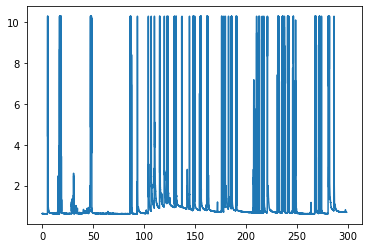

In [151]:
plt.plot(df.sync_time, df.odor)

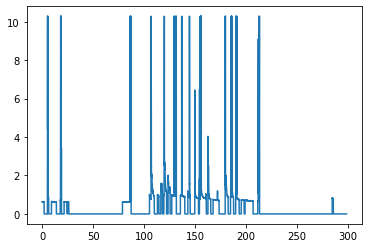

In [152]:
plt.plot(df.sync_time,df.odor_expected)

In [ ]:
# def get_radius(i,loc):
#     if (i == 0):
#         return np.zeros(1)
#     else:
#         radius = np.arange(start = i, stop = 0, step = -1)
#         radius = np.delete(radius,loc)
# #         radius = np.resize(np.insert((a),i,np.zeros(len(delta)-i)),(1,len(delta)))
#         return radius.flatten()

### Create Puff Frame

In [ ]:
# dt = 1
# we = [np.cumsum(windn.U[i:])*dt for i in range(len(windn.U))]
posu = [integrate.cumtrapz(windsm.U[i:],windsm.master_time[i:], axis=0, initial = 0.0) for i in range(len(windsm.U))]
posv = [integrate.cumtrapz(windsm.V[i:],windsm.master_time[i:], axis=0, initial = 0.0) for i in range(len(windsm.V))]

In [ ]:
westeast=pd.DataFrame(posu,columns=['particle{}'.format(x+1) for x in range(len(posu))]) #particle U
northsouth=pd.DataFrame(posv,columns=['particle{}'.format(x+1) for x in range(len(posv))]) #particle in V

In [ ]:
dfi = pd.DataFrame()
dfi['index']=westeast.index
westeast=westeast.T
westeast.set_index(dfi.index, inplace=True)
westeast.columns = ['particle' + str(col) for col in westeast.columns]
delta=pd.DataFrame()
delta[0] = westeast.iloc[:,0]
for i in range(1,len(westeast.columns)):
    delta[i]=westeast['particle' + str(i)].shift(periods=i)

delta.columns = ['particle' + str(col) for col in delta.columns]
delta=delta.fillna(0)
#delta.to_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set05/wind05Run03_Delta.hdf', key='df2', mode='w')

#converting rows to columns for position northsouth
dfi['index1']=northsouth.index
northsouth=northsouth.T
northsouth.set_index(dfi.index1, inplace=True)
northsouth.columns = ['particle' + str(col) for col in northsouth.columns]
gamma=pd.DataFrame()
gamma[0] = northsouth.iloc[:,0]
for i in range(1,len(westeast.columns)):
    gamma[i]=northsouth['particle' + str(i)].shift(periods=i)
    
gamma.columns = ['particle' + str(col) for col in gamma.columns]
gamma=gamma.fillna(0)